In [4]:
from collections import defaultdict
from datetime import datetime
import dill
from itertools import permutations, combinations
import json
import math
from operator import itemgetter
import os
import pickle
import random
import re
import time

import numpy as np
import pandas as pd
import pandas as pd
import scipy

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import little_mallet_wrapper as lmw

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
sns.set(style='ticks', font_scale=1.2)
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

<br><br>

# Load data

In [5]:
decameron_path = '../data/csv/decameron.csv'


In [6]:
decameron_df = pd.read_csv(decameron_path)

In [4]:
len(decameron_df.index)

100

In [5]:
decameron_df.sample(3)

,ID,Day,Story,Narrator,Gender,Text
65,7-6,7,6,pampinea,woman,Maravigliosamente era piaciuta a tutti la nove...
23,3-4,3,4,panfilo,man,"Poi che Filomena, finita la sua novella, si ta..."
53,6-4,6,4,neifile,woman,Tacevasi già la Lauretta e da tutti era stata ...


<br><br>

# Try topic modeling

In [261]:
stopwords = ['il', 'lo', 'la', 'i', 'le', 'gli', 'è', 'tu', 'tuo', 'tua', 'suo', 'sue',
			  'suoi', 'sua', 'loro', 'lei', 'quale', 'quali', 'questa', 'questo', 'cosa',
			  'che', 'non', 'per', 'come', 'egli', 'voi', 'del', 'della', 'così',  'più',
			  'con', 'col', 'cui', 'una', 'qual', 'fu', 'fosse', 'era', 'lui', 'quello',
			  'senza', 'alla', 'dove', 'già', 'ogni', 'vostra', 'vostro', 'vostri', 'vostre',
			  'nostro', 'nostra', 'nostre', 'nostri', 'altro', 'altra', 'altre', 'altri',
			  'molto', 'molta', 'molte', 'molti', 'nel', 'ciò', 'quella', 'bene', 'ben',
			  'ella', 'disse', 'sopra', 'noi', 'alessandro',  'ser', 'esser', 'essere', 'fa', 'fare',
			  'alcuna', 'alcun', 'alcuno', 'ora', 'far', 'quando', 'pietro', 
			  'filippo', 'alberto', 'ferondo', 'gianni', 'fatto',
			  'ché', 'ricciardo', 'riccardo', 'chichibio',
			  'bruno', 'gisippo', 'federigo', 'mai', 'ma', 'poi', 'aveva', 'mio', 'mia', 'masetto',
			  'rinaldo', 'nella', 'nello', 'lor', 'erano', 'lor', 'gerbino', 
			  'gabriotto', 'tanto', 'tanti', 'tante', 'tanta', 'cose', 'delle',
			  'giosefo',
			  'quanto', 'dentro', 'tutto', 'tutta', 'tutti', 'tutte',
			  'nelle', 'giù', 'assai', 'avea', 'dire', 'avendo', 'essendo', 'guiglielmo',
			  'anichino', 'fece', 'sia', 'ancora', 'martuccio', 'efigenia', 'antigono', 'giannetta',
			  'uno', 'avessi', 'quivi', 'sofronia', 'chi',
			  'giacomino', 'ghino', 'allora', 'angiulieri', 'geri', 'pavia',
			  'puccio', 'quindi', 'pirro' , 'perché', 'salabaetto', 'giannotto', 'dico',
			  'dall', 'dal', 'son', 'qui', 'hai', 'sono', 'aver', 'all', 'essi', 'due', 'sapere', 'alle', 'quelle',
			  'queste', 'due', 'tra', 'fine', 'dell', 'del', 'avesse', 'hanno', 'oltre', 'quantunque', 'diceva', 'dice',
			  'tre', 'quegli', 'fatti', 'stato', 'stata', 'dalla', 'agli', 'avere', 'alquanto', 'adunque', 'fanno', 'furono',
			  'cominciò', 'fossero', 'andò', 'incominciò',' solamente', 'degli', 'fatta', 'ebbe', 'coloro', 'questi', 'miei',
			  'nell', 'secondo', 'elle', 'solamente', 'dopo', 'pero', "panfilo", "neifile", "filomena", "dioneo", "fiammetta",
	"emilia", "filostrato", "lauretta", "elissa", "pampinea", 'colei', 'quel', 'state', 'stati', 'stato', 'stata', 'dello',
            'ruggieri', 'buffalmacco', 'biondello', 'perotto', 'beltramo', 'nicostrato', 'paganino', 'ciutazza', 'isabetta',
            'currado', 'cimone', 'beritola', 'arrighetto', 'giuffredi', 'andreuccio', 'arriguccio', 'fortarrigo',
            'ruberto', 'calandrino', 'sicurano', 'ghismunda', 'aldobrandino', 'niccolosa', 'tito', 'negli', 'pasimunda', 'constanzio',
            'griselda', 'gabriello', 'caterina', 'peronella', 'giannello', "guardastagn", 'bernabò', 'ambruogiuolo', 'gulfardo', 'guasparuol',
            'maria', 'simona', 'martellino', 'ciappelletto', 'ercolano', 'melisso', 'magdalena', 'degl', 'quanti', 'poscia',
            'baronci', 'natan', 'guasparuolo', 'gualtieri', 'spinelloccio', 'rinuccio', 'lorenzo', 'pinuccio', 'adriano', 'guiscardo',
            'niccoluccio', 'tingoccio', 'nastagio', 'lambertuccio', 'mitridanes', 'minuccio', 'meuccio', 'salamone', 'tedaldo', 'zima']

In [262]:
training_texts = []
original_texts = []
training_narrators = []
training_genders = []

for i, r in decameron_df.iterrows():
    _chunks = [' '.join(r['Text'].split()[i:i+200]) for i in range(0, len(r['Text'].split()), 200)]
    _processed_chunks = [lmw.process_string(c, stop_words=stopwords, remove_short_words=False).strip() for c in _chunks]
    _processed_chunks = [c for c in _processed_chunks if len(c.split()) >= 20]

    for i, c in enumerate(_processed_chunks):
        training_texts.append(c)
        original_texts.append(_chunks[i])
        training_narrators.append(r['Narrator'])
        training_genders.append(r['Gender'])

len(training_texts), len(training_narrators), len(training_genders)

(1203, 1203, 1203)

In [18]:
num_topics = 20  
output_directory_path = 'output' 
#path_to_mallet = '/Volumes/Passport-1/packages/mallet-2.0.8/bin/mallet'
path_to_mallet = "~/mallet-2.0.8/bin/mallet"


In [264]:
topic_keys, topic_distributions = lmw.quick_train_topic_model(path_to_mallet, 
                                                              output_directory_path, 
                                                              num_topics, 
                                                              training_texts)

Importing data...
Complete
Training topic model...
Complete


In [171]:
assert(len(topic_distributions) == len(training_texts))

In [266]:
for i, t in enumerate(topic_keys):
    print(i, '\t', ' '.join(t[:20]))

0 	 prete geloso badessa belcolore orto mutolo monache castaldo doglio cinque tabarro sere nuto cherico volea monaca mortaio favella asino monistero
1 	 donna camera casa letto marito uscio notte fante moglie allato dormire lume zeppa sentì entrò cena chetamente pianamente vide poté
2 	 donne uomini novella reina chiamato città uomo giovani volte nome gentili belle forse oggi ciascuno bella meno intendo materia alcuni
3 	 denari oro mercatanti mercatantia mercatante soldano borsa fiorin quantità panni genova cinquecento fiorini dugento genovesi camiscia ragione mille fondaco valeva
4 	 dio vero rispose certo pur voglio idio niuna abbia uomo detto avete anzi credo gran udendo possa mondo parole farò
5 	 fratelli morte morto ninetta pellegrino pianto costoro corpo sepellito ucciso parenti salute sepoltura lagrime stramba pasquino folco vivo salvia pienamente
6 	 giovane padre madre figliuola costei giovani parenti amor innamorò figliuolo lizio anni vescovo moglie palermo bellissima monna

In [173]:
for _topic in range(0, num_topics):
    print('---------------------------------------------------------------------------')
    print('TOPIC ' + str(_topic) + ': ' + ' '.join(topic_keys[_topic][:5]))
    print('---------------------------------------------------------------------------')
    print()
    for p, d in lmw.get_top_docs(original_texts, topic_distributions, topic_index=_topic, n=3):
        print(round(p, 4), d)
        print()

---------------------------------------------------------------------------
TOPIC 0: tito zeppa amico spinelloccio roma
---------------------------------------------------------------------------

0.6463 quale sopra ogni sua felicità e più che la propria vita l'amava. E che quello che io dico sia vero e più da commendare che quello che voi fatto avavate, riguardisi a parte a parte. Che io giovane e filosofo sia come Gisippo, il viso mio e gli studii, senza più lungo sermon farne, il possono dichiarare: una medesima età è la sua e la mia, e con pari passo sempre proceduti siamo studiando. E il vero che egli è ateniese e io romano. Se della gloria delle città si disputerà, io dirò che io sia di città libera e egli di tributaria; io dirò che io sia di città donna di tutto il mondo e egli di città obediente alla mia; io dirò che io sia di città fiorentissima d'arme, d'imperio e di studii dove egli non potrà la sua se non di studii commendare. Oltre a questo, quantunque voi qui scolar mi ve

In [287]:
topic_keys_edited = ['religion/nuns', '1', '2', 'mercantile', '4', 'death/grief', 'love', 'seafaring', 'religion/abbots,friars', 
                    'religion/sin', '10', 'agrarian', 'religion/churchgoing', 'fortune', '14', 'religion/abrahamic',
                    'family/marriage,children', 'urban', '18', 'gentility/nobility']
len(topic_keys_edited)

20

In [305]:
def plot_categories_by_topics_heatmap(labels, 
                                      topic_distributions, 
                                      topic_keys, 
                                      output_path=None,
                                      target_labels=None,
                                      dim=None):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        for _topic_index, _probability in enumerate(_distribution):
            # skip 1, 2, 4, 10, 14, 18
            if _topic_index in [0,3,5,6,7,8,9,11,12,13,15,16,17,19]:
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': topic_keys[_topic_index]})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    
    df_wide = df_to_plot.pivot_table(index='Category', 
                                     columns='Topic', 
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
   
    # remove topics that overpower the others
    #print(df_to_plot)
    
    
    
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap='Blues', linewidths=2)    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

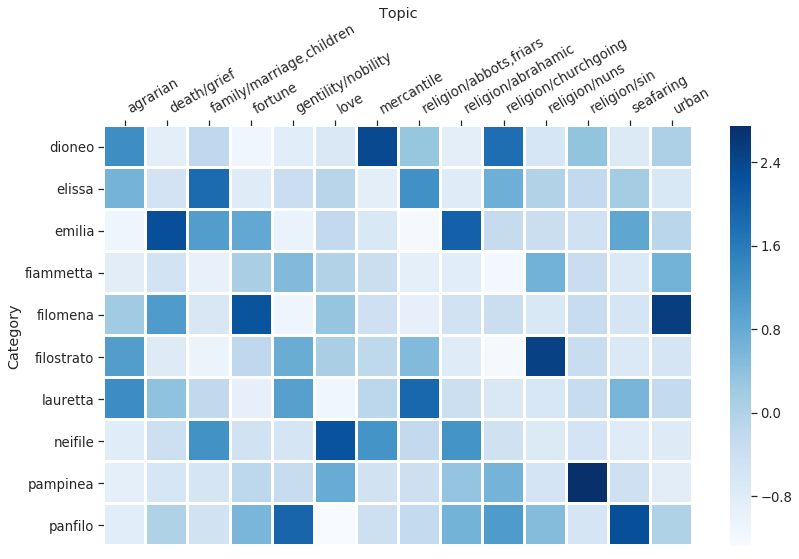

In [307]:
plot_categories_by_topics_heatmap(training_narrators,
                                  topic_distributions,
                                  topic_keys_edited, 
                                  output_directory_path + '/narrators_by_topics.pdf',
                                  dim=(12,8))


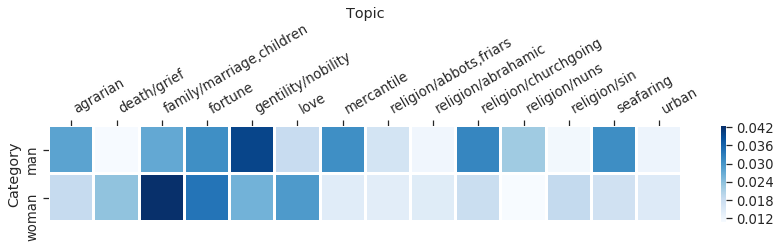

In [304]:
def plot_categories_by_topics_heatmap(labels, 
                                      topic_distributions, 
                                      topic_keys, 
                                      output_path=None,
                                      target_labels=None,
                                      dim=None):
    
    # Combine the labels and distributions into a list of dictionaries.
    dicts_to_plot = []
    for _label, _distribution in zip(labels, topic_distributions):
        for _topic_index, _probability in enumerate(_distribution):
            # skip 1, 2, 4, 14, 10, 18
            if _topic_index in [0,3,5,6,7,8,9,11,12,13,15,16,17,19]:
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': topic_keys[_topic_index]})

    # Create a dataframe, format it for the heatmap function, and normalize the columns.
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category', 
                                     columns='Topic', 
                                     values='Probability')
    df_norm_col=(df_wide-df_wide.mean())/df_wide.std()
        
    # Show the final plot.
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_wide, cmap='Blues', linewidths=2)    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()
    
plot_categories_by_topics_heatmap(training_genders,
                                  topic_distributions,
                                  topic_keys_edited, 
                                  output_directory_path + '/gender_by_topics.pdf',
                                  dim=(12,3.5))

<br><br>

# Try logistic regression

In [7]:
# getting top n words
vocab_freq_path = '../data/csv/vocab-word-freqs.csv'
vocab_freq_df = pd.read_csv(vocab_freq_path)
vocab_freq_df.rename(columns={vocab_freq_df.columns[0]: "word", vocab_freq_df.columns[1]: "freq"}, inplace = True)


In [8]:
def get_top_n_words(n):
    return vocab_freq_df.head(n)["word"].tolist()
    

In [20]:
top_n = 100
top_n_words = get_top_n_words(top_n)

def keep_top_n_words(text):
    #text = decameron_df.iloc[0]["Text"].split()
    text = text.split()
    text = [word.lower() for word in text]
    text_cleaned = [word for word in text if word in top_n_words]
    return " ".join(text_cleaned)

decameron_df["Text_cleaned"] = decameron_df.apply(lambda x: keep_top_n_words(x["Text"]), axis=1)

decameron_df.head()

,ID,Day,Story,Narrator,Gender,Text,Text_cleaned
0,1-1,1,1,panfilo,man,"–Convenevole cosa è, carissime donne, che cias...",cosa che cosa la quale di il quale di fu le pe...
1,1-2,1,2,neifile,woman,La novella di Panfilo fu in parte risa e tutta...,la di fu in la quale al suo essendo di lui le ...
2,1-3,1,3,filomena,woman,"Poi che, commendata da tutti la novella di Nei...",poi da tutti la di ella si come alla così comi...
3,1-4,1,4,dioneo,man,Già si tacea Filomena dalla sua novella espedi...,già si sua quando che di lei senza altro già p...
4,1-5,1,5,fiammetta,woman,La novella da Dioneo raccontata prima con un p...,la da con un di delle con nel loro ne poi del ...


In [10]:
# first, we want to split into train and test datasets
# for training, we want to make sure that we have chunked into
# small pieces of text. We are going to divide the text into 100-word
# pieces (and not worry about leftover for simplicity)
# we also want to make sure that the train chunks come from stories
# that do not overlap with the test stories

# so to start, we will sample 80% (80) of the stories for train,
# 20% for test, and then we will chunk them

# num_train is the number of stories that will be used for training; 
# 10 - num_train is number used for test, per storyteller
def storyteller_train_test_split(storyteller, num_train=8):
	# get story ids for the story teller
	storyteller_ids =  decameron_df[decameron_df['Narrator']==storyteller]['ID'].tolist()
	train_set_story_ids = random.sample(storyteller_ids, 8)
	test_set_story_ids = [x for x in storyteller_ids if x not in train_set_story_ids]
	return train_set_story_ids, test_set_story_ids

# 30 stories by men, 70 by women
# so for 80/20 train/test, we want 24 of men, 56 of the women for train
def gender_test_train_split(gender, prop_train=.8):
	gender_ids =  decameron_df[decameron_df['Gender']==gender]['ID'].tolist()
	num_train = int(prop_train * len(gender_ids))
	train_gender_ids = random.sample(gender_ids, num_train)
	test_gender_ids = [x for x in gender_ids if x not in train_gender_ids]
	return train_gender_ids, test_gender_ids

def pair_test_train_split(storyteller1, storyteller2, num_train=8):
	train_1, test_1 = storyteller_train_test_split(storyteller1, num_train)
	train_2, test_2 = storyteller_train_test_split(storyteller2, num_train)
	train_1.extend(train_2)
	test_1.extend(test_2)
	return train_1, test_1

# construct the training and test sets. We will chunk each story
# into n words (not caring about the remainder) and each chunk will
# be a data point. The corresponding label will be the storyteller for
# to story to which the chunk belongs 
def chunk_story(story_id, n):
    story = decameron_df[decameron_df['ID']==story_id]
    text = story['Text'].item()
    if use_top_n_words:
        text = story['Text_cleaned'].item()

    # there has to be a better way to do this, but whatever
    words = text.split()
    # rejoin words every n words, put into list
    story_chunks = [" ".join(words[i:i+n]) for i in range(0, len(words), n)]
    return story_chunks, story['Narrator'].item(), story['Gender'].item()

# iterate through train story ids, chunk story, put into train set; same
# for test set
def create_data_set(story_ids, chunk_size, use_gender):
    texts = []
    labels = []
    print("Using {} top words: {}".format(top_n, use_top_n_words))
    for story_id in story_ids:
        # heinous factoring...whatever
        story_chunks, storyteller, gender = chunk_story(story_id, chunk_size)
        for chunk in story_chunks:
            # add each chunk as a traing put for that storyteller
            texts.append(chunk)
            if use_gender:
                labels.append(gender)
            else:
                labels.append(storyteller)
    return texts, labels

<br><br>
## Storytellers

In [11]:
def get_storyteller_datasets():
    train_set_story_ids = []
    test_set_story_ids = []

    chunk_size = 100

    for storyteller in decameron_df['Narrator'].unique():
        storyteller_train_ids, storyteller_test_ids = storyteller_train_test_split(storyteller)
        train_set_story_ids.extend(storyteller_train_ids)
        test_set_story_ids.extend(storyteller_test_ids)

    train_texts, train_labels = create_data_set(train_set_story_ids, chunk_size, use_gender=False)
    test_texts, test_labels = create_data_set(test_set_story_ids, chunk_size, use_gender=False)
    return train_texts, train_labels, test_texts, test_labels

In [68]:
use_top_n_words = False
train_texts, train_labels, test_texts, test_labels = get_storyteller_datasets()
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

Using 100 top words: False
Using 100 top words: False


(1951, 1951, 438, 438)

In [69]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [70]:
model = LogisticRegression(C=1, multi_class="ovr").fit(X_train, train_labels)
predictions = model.predict(X_test)

In [71]:
print(classification_report(test_labels, predictions))
lr_results = classification_report(test_labels, predictions, output_dict=True)

# can we do better than just checking "did we get it right"; instead do top 3
# confusion matrix all the speakers by the speakers; who did we classify as whom

#lr_results['accuracy']

              precision    recall  f1-score   support

      dioneo       0.16      0.22      0.19        54
      elissa       0.00      0.00      0.00        39
      emilia       0.00      0.00      0.00        35
   fiammetta       0.12      0.05      0.07        62
    filomena       0.10      0.02      0.03        56
  filostrato       0.00      0.00      0.00        33
    lauretta       0.06      0.02      0.03        59
     neifile       0.00      0.00      0.00        31
    pampinea       0.08      0.25      0.12        24
     panfilo       0.07      0.36      0.12        45

    accuracy                           0.09       438
   macro avg       0.06      0.09      0.06       438
weighted avg       0.07      0.09      0.06       438



/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/pyth

In [12]:
# run above task n times
#print(lr_results)

column_names = ['run_id','dioneo', 'elissa', 'emilia', 'fiammetta', 'filomena', 
                    'filostrato', 'lauretta', 'neifile', 'pampinea', 'panfilo', 
                    'accuracy', 'macro_avg', 'weighted_avg']
results_df = df = pd.DataFrame(columns = column_names)

f1_names = ['dioneo', 'elissa', 'emilia', 'fiammetta', 'filomena', 
                    'filostrato', 'lauretta', 'neifile', 'pampinea', 'panfilo']
f1_df = df = pd.DataFrame(columns = f1_names)  
    

In [13]:
def run_lr_n_times(n, results_df, f1_df, ovr=False):
    # dataframe with results   
    
    for i in range(1,n+1):
        print("Running {} of {}".format(i, n))
        train_texts, train_labels, test_texts, test_labels = get_storyteller_datasets()

        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(train_texts)
        X_test = vectorizer.transform(test_texts)
        
        model = LogisticRegression(C=1).fit(X_train, train_labels)
        if ovr:
            print("OVR: True")
            model = LogisticRegression(C=1, multi_class='ovr').fit(X_train, train_labels)
        
        predictions = model.predict(X_test)

        lr_results = classification_report(test_labels, predictions, output_dict=True)
    
        results_df = results_df.append({'run_id': i, 
                                        'dioneo': lr_results['dioneo'],
                                        'elissa': lr_results['elissa'],
                                        'emilia': lr_results['emilia'],
                                        'fiammetta': lr_results['fiammetta'],
                                        'filomena': lr_results['filomena'],
                                        'filostrato': lr_results['filostrato'],
                                        'lauretta': lr_results['lauretta'],
                                        'neifile': lr_results['neifile'],
                                        'pampinea': lr_results['pampinea'],
                                        'panfilo': lr_results['panfilo'],
                                        'accuracy': lr_results['accuracy'],
                                        'macro_avg': lr_results['macro avg'],
                                        'weighted_avg': lr_results['weighted avg'],
                                       }, ignore_index=True)
        
        f1_df = f1_df.append({          'dioneo': lr_results['dioneo']['f1-score'],
                                        'elissa': lr_results['elissa']['f1-score'],
                                        'emilia': lr_results['emilia']['f1-score'],
                                        'fiammetta': lr_results['fiammetta']['f1-score'],
                                        'filomena': lr_results['filomena']['f1-score'],
                                        'filostrato': lr_results['filostrato']['f1-score'],
                                        'lauretta': lr_results['lauretta']['f1-score'],
                                        'neifile': lr_results['neifile']['f1-score'],
                                        'pampinea': lr_results['pampinea']['f1-score'],
                                        'panfilo': lr_results['panfilo']['f1-score'],
                                       }, ignore_index=True)
    
    return results_df, f1_df

In [21]:
runs = 100
use_top_n_words = True
n_results, f1_results = run_lr_n_times(runs, results_df, f1_df, ovr=True)

Running 1 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 2 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 3 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 4 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 5 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 6 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 7 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 8 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 9 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 10 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 11 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 12 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 13 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 14 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 15 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 16 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 17 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 18 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 19 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 20 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 21 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 22 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 23 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 24 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 25 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 26 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 27 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 28 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 29 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 30 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 31 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 32 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 33 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 34 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 35 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 36 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 37 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 38 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 39 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 40 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 41 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 42 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 43 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 44 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 45 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 46 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 47 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 48 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 49 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 50 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 51 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 52 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 53 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 54 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 55 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 56 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 57 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 58 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 59 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 60 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 61 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 62 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 63 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 64 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 65 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 66 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 67 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 68 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 69 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 70 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 71 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 72 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 73 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 74 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 75 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 76 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 77 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 78 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 79 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 80 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 81 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 82 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 83 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 84 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 85 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 86 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 87 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 88 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 89 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 90 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 91 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 92 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 93 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 94 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 95 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 96 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 97 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True
Running 98 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 99 of 100
Using 100 top words: True
Using 100 top words: True
OVR: True
Running 100 of 100
Using 100 top words: True
Using 100 top words: True


/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cooper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


OVR: True


In [15]:
n_results

,run_id,dioneo,elissa,emilia,fiammetta,filomena,filostrato,lauretta,neifile,pampinea,panfilo,accuracy,macro_avg,weighted_avg
0,1,"{'precision': 0.15492957746478872, 'recall': 0...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.2, 'recall': 0.078431372549019...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.0967741935483871, 'recall': 0....","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.039603960396039604, 'recall': ...","{'precision': 0.23369565217391305, 'recall': 0...",0.131783,"{'precision': 0.07250033835831285, 'recall': 0...","{'precision': 0.09178575385496013, 'recall': 0..."
1,2,"{'precision': 0.12173913043478261, 'recall': 0...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.0625, 'recall': 0.032258064516...","{'precision': 0.022222222222222223, 'recall': ...","{'precision': 0.037037037037037035, 'recall': ...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.0975609756097561, 'recall': 0....","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.17857142857142858, 'recall': 0...",0.126195,"{'precision': 0.05196307938752266, 'recall': 0...","{'precision': 0.04674207625051521, 'recall': 0..."
2,3,"{'precision': 0.08878504672897196, 'recall': 0...","{'precision': 0.017857142857142856, 'recall': ...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.10344827586206896, 'recall': 0...","{'precision': 0.019230769230769232, 'recall': ...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.047619047619047616, 'recall': ...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.1111111111111111, 'recall': 0....","{'precision': 0.18461538461538463, 'recall': 0...",0.091205,"{'precision': 0.05726667780244963, 'recall': 0...","{'precision': 0.08474239845090634, 'recall': 0..."
3,4,"{'precision': 0.19230769230769232, 'recall': 0...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.075, 'recall': 0.0588235294117...","{'precision': 0.034482758620689655, 'recall': ...","{'precision': 0.14285714285714285, 'recall': 0...","{'precision': 0.043478260869565216, 'recall': ...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.041666666666666664, 'recall': ...","{'precision': 0.16299559471365638, 'recall': 0...",0.113309,"{'precision': 0.0692788116035413, 'recall': 0....","{'precision': 0.07009626021081443, 'recall': 0..."
4,5,"{'precision': 0.10909090909090909, 'recall': 0...","{'precision': 0.14285714285714285, 'recall': 0...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.0196078431372549, 'recall': 0....","{'precision': 0.04, 'recall': 0.10714285714285...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.04878048780487805, 'recall': 0...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.07142857142857142, 'recall': 0...","{'precision': 0.1871345029239766, 'recall': 0....",0.103950,"{'precision': 0.06188994572427329, 'recall': 0...","{'precision': 0.07775497290259806, 'recall': 0..."
5,6,"{'precision': 0.15126050420168066, 'recall': 0...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.2222222222222222, 'recall': 0....","{'precision': 0.030303030303030304, 'recall': ...","{'precision': 0.15384615384615385, 'recall': 0...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.10416666666666667, 'recall': 0...","{'precision': 0.0, 'recall': 0.0, 'f1-score': ...","{'precision': 0.0273972602739726, 'recall': 0....","{'precision': 0.19642857142857142, 'recall': 0...",0.088141,"{'precision': 0.08856244089422977, 'recall': 0...","{'precision': 0.11927289090387437, 'recall': 0..."
6,7,"{'precision': 0.12844036697247707, 'recall': 0..

In [16]:
f1_results

,dioneo,elissa,emilia,fiammetta,filomena,filostrato,lauretta,neifile,pampinea,panfilo
0,0.169231,0.000000,0.000000,0.112676,0.000000,0.000000,0.126316,0.000000,0.063492,0.300699
1,0.176101,0.000000,0.042553,0.016667,0.029412,0.000000,0.102564,0.000000,0.000000,0.290323
2,0.143939,0.023529,0.000000,0.101695,0.019802,0.000000,0.036697,0.000000,0.048000,0.177778
3,0.218978,0.000000,0.000000,0.065934,0.047059,0.048780,0.024390,0.000000,0.054795,0.239482
4,0.094488,0.037736,0.000000,0.019608,0.058252,0.000000,0.051282,0.000000,0.087719,0.250000
5,0.200000,0.000000,0.052632,0.032258,0.041237,0.000000,0.086957,0.000000,0.042553,0.174603
6,0.198582,0.000000,0.000000,0.056338,0.035088,0.000000,0.028571,0.000000,0.043956,0.301587
7,0.171429,0.000000,0.000000,0.020408,0.026316,0.000000,0.070175,0.000000,0.109589,0.251012
8,0.078125,0.057143,0.000000,0.060606,0.000000,0.000000,0.037037,0.000000,0.070588,0.187755
9,0.175000,0.041667,0.048780,0.053097,0.025316,0.000000,0.052632,0.000000,0.000000,0.234043


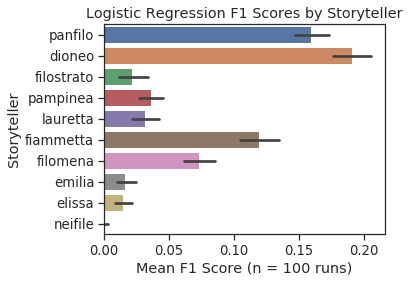

In [22]:
unstacked = f1_results.unstack().to_frame()
p = sns.barplot(
    y=unstacked.index.get_level_values(0),
    x=unstacked[0], order=["panfilo", "dioneo", "filostrato", 'pampinea', 'lauretta', 'fiammetta', 'filomena', 'emilia', 'elissa', 'neifile'])

p.set_title('Logistic Regression F1 Scores by Storyteller')
p.set_ylabel('Storyteller')
p.set_xlabel('Mean F1 Score (n = 100 runs)')
plt.subplots_adjust(bottom=0.15, left=0.25)
plt.savefig(output_directory_path + '/storyteller_f1_top_100_ovr.pdf')


<br><br>

# PMI

p(narrator, word) = log(p(word | narrator) / p(word))

In [26]:
word_count_dict = defaultdict(int)
narrator_word_count_dict = defaultdict(lambda: defaultdict(int))

for i, r in decameron_df.iterrows():
    _text = re.sub(r'[.,!?:\-()]', ' ', r['Text'])
    for _word in _text.lower().split():
        word_count_dict[_word] += 1
        narrator_word_count_dict[r['Narrator']][_word] += 1

In [105]:
vocab_a = []

for w, c in word_count_dict.items(): 
    _appears_in_all = True
    for n in decameron_df['Narrator'].unique():
        if narrator_word_count_dict[n][w] < 5:
            _appears_in_all = False
    if _appears_in_all:
        vocab_a.append(w)

#print(vocab_a)
print(len(vocab_a))

# remove some generic words from vocab
stopwords_pmi = ['è', 'che', 'la', 'quale', 'e', 'di', 'fu', 'le', 
                 'per', 'col', 'aveva', 'avere', 'ha', 'il', 'lo', 'gli', 'i', 'de',
                 'in', 'ciò', 'ho']
vocab = [x for x in vocab_a if x not in stopwords_pmi]
print(len(vocab))
print(vocab)



256
236
['cosa', 'donne', 'fa', 'nome', 'colui', 'tutte', 'io', 'al', 'sì', 'come', 'da', 'una', 'delle', 'sue', 'cose', 'acciò', 'quella', 'lui', 'si', 'sempre', 'sia', 'noi', 'suo', 'sono', 'così', 'sé', 'esser', 'a', 'alle', 'quali', 'senza', 'né', 'parte', 'se', 'dio', 'non', 'ci', 'alcun', 'ma', 'dalla', 'sua', 'bene', 'suoi', 'vita', 'ora', 'con', 'son', 'della', 'forse', 'nel', 'tanto', 'più', 'verso', 'modo', 'volta', 'alla', 'esso', 'niuna', 'del', 'o', 'quegli', 'fosse', "'l", 'nella', 'novella', 'quel', 'uomini', 'adunque', 'essendo', 'gran', 'venire', 'messer', 're', 'egli', 'li', 'fatti', 'volte', "de'", 'molto', 'là', 'tutti', 'cui', 'potesse', 'era', 'chi', 'alcuna', 'loro', 'sopra', 'questa', 'stato', 'venne', 'un', 'casa', 'persona', 'volesse', 'dir', 'secondo', 'lor', 'tutto', 'dove', 'questo', 'avea', 'vergogna', 'quando', 'uno', 'ne', 'facesse', 'altro', 'alcuno', "a'", 'dire', 'vero', 'chiamato', 'oltre', 'forte', 'vi', 'tra', 'altra', 'quanto', 'mai', 'mani', 'ogn

In [106]:
word_probability_dict = {w: c/float(sum(word_count_dict.values())) for w, c in word_count_dict.items() if w in vocab}
narrator_word_probability_dict = {}
for n, _word_count_dict in narrator_word_count_dict.items():
    if n not in narrator_word_probability_dict:
        narrator_word_probability_dict[n] = {}
    for w, c in _word_count_dict.items():
        if w in vocab:
            narrator_word_probability_dict[n][w] = c/float(sum(narrator_word_count_dict[n].values()))
                                  

In [107]:
narrator_word_pmi_dict = {}

for n, _word_probability_dict in narrator_word_probability_dict.items():
    if n not in narrator_word_pmi_dict:
        narrator_word_pmi_dict[n] = {}
    for w, p in _word_probability_dict.items():
        narrator_word_pmi_dict[n][w] = math.log(p / word_probability_dict[w])

In [108]:
for n, _word_pmi_dict in narrator_word_pmi_dict.items():
    print('-----------------------------')
    print(n)
    print('-----------------------------')
    for w, pmi in sorted(_word_pmi_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(round(pmi, 3), '\t', w)
    print('...')
    for w, pmi in sorted(_word_pmi_dict.items(), key=lambda x: x[1], reverse=True)[-10:]:
        print(round(pmi, 3), '\t', w)
    print()

-----------------------------
panfilo
-----------------------------
0.66 	 messer
0.579 	 giorno
0.468 	 uomini
0.461 	 sopra
0.403 	 bella
0.398 	 potesse
0.361 	 suoi
0.347 	 dopo
0.339 	 idio
0.334 	 padre
...
-0.451 	 questa
-0.486 	 volesse
-0.486 	 –
-0.522 	 giovane
-0.53 	 consiglio
-0.573 	 reina
-0.613 	 femina
-0.72 	 viso
-0.727 	 vergogna
-0.727 	 buona

-----------------------------
neifile
-----------------------------
0.622 	 andare
0.585 	 vostra
0.584 	 guisa
0.575 	 dicendo
0.532 	 marito
0.523 	 chiamato
0.523 	 re
0.498 	 perché
0.452 	 piè
0.431 	 parole
...
-0.506 	 medesimo
-0.538 	 messer
-0.578 	 modo
-0.631 	 nelle
-0.654 	 festa
-0.684 	 idio
-0.827 	 volta
-0.86 	 dalla
-1.11 	 volte
-1.259 	 notte

-----------------------------
filomena
-----------------------------
0.625 	 vergogna
0.553 	 certo
0.512 	 moglie
0.499 	 te
0.478 	 dir
0.449 	 sia
0.442 	 forse
0.39 	 sé
0.373 	 via
0.362 	 tosto
...
-0.61 	 sopra
-0.645 	 poco
-0.646 	 rispose
-0.76 	 vostr